In [1]:
#from riotwatcher import LolWatcher, ApiError
import pandas as pd
import requests
import matplotlib.pyplot as plt
import json
import time
import sys

APIKey = 'RGAPI-1d209705-0cba-40e2-aae6-018ae520cd3a'
region = 'na1'
rank = 'b'
division = 'c'
displace = 1
option = '-1'
username = ''

def getNextInfo(region, rank, division, page, APIKey):
    url = "https://" + region + ".api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/" + rank + "/" + division + "?page=" + str(page) + "&api_key=" + APIKey
    response = requests.get(url)
    return response.json()

def getNextUrl(region, rank, division, page, APIKey):
    return "https://" + region + ".api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/" + rank + "/" + division + "?page=" + str(page) + "&api_key=" + APIKey

def getUrl(region, rank, division, APIKey):
    global displace
    if rank == 'MASTER':
        temp = "https://" + region + ".api.riotgames.com/lol/league/v4/masterleagues/by-queue/RANKED_SOLO_5x5?api_key=" + APIKey
        displace = 1001
        return temp
    elif rank == 'GRANDMASTER':
        temp = "https://" + region + ".api.riotgames.com/lol/league/v4/grandmasterleagues/by-queue/RANKED_SOLO_5x5?api_key=" + APIKey
        displace = 301
        return temp
    elif rank == 'CHALLENGER':
        temp = "https://" + region + ".api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key=" + APIKey
        displace = 1
        return temp
    else:
        temp = "https://" + region + ".api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/" + rank + "/" + division + "?page=1&api_key=" + APIKey
        return temp

def getPlayerInput():
    print("\nLet's check players info from any specific rank")
    global region, rank, division
    region = (str)(input('Enter the region (ONLY BR1, EUN1, EUW1, JP1, KR, LA1, LA2, NA1, OC1, RU, TR1 are supported): '))
    #region = 'NA1'
    rank = (str)(input('Enter the rank (IRON, BRONZE, SILVER, GOLD, PLATINUM, DIAMOND, MASTER, GRANDMASTER, CHALLENGER): '))
    #rank = 'MASTER'
    if (rank == 'MASTER' or rank == 'GRANDMASTER' or rank == 'CHALLENGER'):
        division = 'I' #These ranks only have one division, so the division is defaulted to I
        return
    division = (str)(input('Enter the division (I, II, III, IV): '))
    #division = 'I'
    
def getUserOption():
    global option
    print('Choose an option: ')
    print('1 - Search a player\'s ranked stats (NA only for now)')
    print('2 - Display a list of players in any rank')
    print('3 - Grab a list of all players in any region and save to csv file')
    print('0 - Quit')
    option = (str)(input('option: '))

def getPlayerRankedStats(df): #Only NA1 region for now
    #global region
    #region = (str)(input('Enter the region (ONLY BR1, EUN1, EUW1, JP1, KR, LA1, LA2, NA1, OC1, RU, TR1 are supported): '))
    username = ''
    while username != '!q':
        username = (str)(input('Enter the name here (!q to quit): '))
        if username == '!q':
            sys.exit()
        df['Winrate'] = df.apply(lambda row: '{0:.0%}'.format((row.wins / (row.wins + row.losses))), axis=1)
        print(df.loc[df['summonerName'].str.lower()==username.lower()][['summonerName','tier','rank','leaguePoints','Winrate']])
    return

def getPlayerBase(region):
    start_time = time.time()
    global rank, division, nextPage
    bigdf = pd.DataFrame()
    for rank in ['CHALLENGER','GRANDMASTER','MASTER']:
        tempdf = pd.read_json(getUrl(region,rank,division,APIKey))        
        tempdf = pd.json_normalize(tempdf['entries'])
        tempdf['tier'] = rank
        bigdf = bigdf.append(tempdf, ignore_index=True)
    time.sleep(120)
    for rank in ['DIAMOND','PLATINUM','GOLD','SILVER','BRONZE','IRON']:
        for division in ['I','II','III','IV']:
            time.sleep(60)
            nextPage = 2
            tempdf2 = pd.read_json(getUrl(region, rank, division, APIKey))
            nextInfo = pd.read_json(getNextUrl(region,rank,division,nextPage,APIKey))
            tempNextInfo = nextInfo
            while not (tempNextInfo.empty): #Checks if the next page of data is empty on the API
                tempdf2 = tempdf2.append(tempNextInfo, ignore_index = True) 
                nextPage = nextPage + 1
                tempNextInfo = pd.read_json(getNextUrl(region,rank,division,nextPage,APIKey))
                time.sleep(1)
            bigdf = bigdf.append(tempdf2, ignore_index=True)
    
    bigdf['tier'] = pd.Categorical(bigdf['tier'], ordered=True, categories=['IRON','BRONZE','SILVER','GOLD','PLATINUM','DIAMOND','MASTER','GRANDMASTER','CHALLENGER'])
    bigdf['rank'] = pd.Categorical(bigdf['rank'], ordered=True, categories=['IV','III','II','I'])
    bigdf.sort_values(['tier','rank','leaguePoints'], ascending=False, inplace=True)
    bigdf.drop_duplicates('summonerName',keep='first',inplace=True)
    bigdf = bigdf.reset_index(drop=True)
    bigdf.index = bigdf.index + 1
    bigdf['Winrate'] = bigdf.apply(lambda row: '{0:.0%}'.format((row.wins / (row.wins + row.losses))), axis=1)
    print(bigdf[['summonerName','tier','rank','leaguePoints','Winrate']])
    bigdf.to_csv(f'{region}PlayerBase.csv') 
    print("This program took" ,time.time() - start_time, "seconds to execute.")
    

def getListSpecificRank():
    getPlayerInput()
    global nextPage
    nextPage = 2
    df = pd.DataFrame()
    print("Here is a current list of players in " + rank + " " + division)
    if (rank == 'IRON' or rank == 'BRONZE' or rank == 'SILVER' or rank == 'GOLD' or rank == 'PLATINUM' or rank == 'DIAMOND'):
        df = pd.read_json(getUrl(region, rank, division, APIKey))
        nextInfo = pd.read_json(getNextUrl(region,rank,division,nextPage,APIKey))
        tempNextInfo = nextInfo
        while not (tempNextInfo.empty): #Checks if the next page of data is empty on the API
            df = df.append(tempNextInfo, ignore_index = True) 
            nextPage = nextPage + 1
            tempNextInfo = pd.read_json(getNextUrl(region,rank,division,nextPage,APIKey))
            time.sleep(.93) # .90 was too fast under Riot's request limitations while .95 isn't, so I settled with .93
    elif (rank == 'CHALLENGER' or rank == 'GRANDMASTER' or rank == 'MASTER'):    
        df = pd.read_json(getUrl(region,rank,division,APIKey))        
        df = pd.json_normalize(df['entries'])
        df['tier'] = rank
    df.sort_values(by=['leaguePoints'], ascending=False, inplace=True)
    df = df.reset_index(drop=True)
    df.index = df.index + displace
    df['Winrate'] = df.apply(lambda row: '{0:.0%}'.format((row.wins / (row.wins + row.losses))), axis=1)
    print(df[['summonerName','tier','rank','leaguePoints', 'Winrate']])
    nameInput = ''
    while nameInput != '!q':
        nameInput = (str)(input('Want to search for someone? Enter the name here (!q to quit or !csv to save): '))
        if nameInput == '!q':
            sys.exit()
        if nameInput == '!csv':
            df.to_csv(f'{region}{rank}{division}.csv')
        print(df.loc[df['summonerName'].str.lower()==nameInput.lower()][['summonerName','leaguePoints','Winrate']])

def main():
    getUserOption()
    if option == '1':
        df = pd.read_csv("NA1PLAYERBASE.csv", low_memory=False)
        getPlayerRankedStats(df)
    elif option == '2':
        getListSpecificRank()
    elif option == '3':
        global region
        region = (str)(input('region: '))
        getPlayerBase(region)
    elif option == '0':
        sys.exit()
    else:
        print("Invalid option: ending program")
        sys.exit()
    
    
if __name__ == "__main__":
    main()

Choose an option: 
1 - Search a player's ranked stats (NA only for now)
2 - Display a list of players in any rank
3 - Grab a list of all players in any region and save to csv file
0 - Quit


option:  2



Let's check players info from any specific rank


Enter the region (ONLY BR1, EUN1, EUW1, JP1, KR, LA1, LA2, NA1, OC1, RU, TR1 are supported):  NA1
Enter the rank (IRON, BRONZE, SILVER, GOLD, PLATINUM, DIAMOND, MASTER, GRANDMASTER, CHALLENGER):  CHALLENGER


Here is a current list of players in CHALLENGER I
     summonerName        tier rank  leaguePoints Winrate
1         C9 Zven  CHALLENGER    I          1560     57%
2       Josedeodo  CHALLENGER    I          1350     59%
3     qpalzmwoiaj  CHALLENGER    I          1342     53%
4       C9 ZVENNN  CHALLENGER    I          1308     62%
5           41205  CHALLENGER    I          1301     54%
..            ...         ...  ...           ...     ...
296      kníghtzz  CHALLENGER    I           449     56%
297        Meteos  CHALLENGER    I           448     51%
298     IWU Fizzi  CHALLENGER    I           443     53%
299        im avi  CHALLENGER    I           438     54%
300  GropedByGods  CHALLENGER    I           423     55%

[300 rows x 5 columns]


Want to search for someone? Enter the name here (!q to quit or !csv to save):  firetheft


Empty DataFrame
Columns: [summonerName, leaguePoints, Winrate]
Index: []


Want to search for someone? Enter the name here (!q to quit or !csv to save):  Koh B


    summonerName  leaguePoints Winrate
192        Koh B           554     51%


Want to search for someone? Enter the name here (!q to quit or !csv to save):  !q


SystemExit: 

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


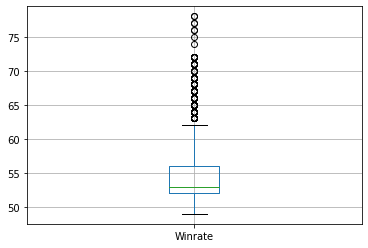

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("data.csv")
#df['Winrate'] = df.apply(lambda row: '{0:.0%}'.format((row.wins / (row.wins + row.losses))), axis=1)
df['gamesPlayed'] = df.apply(lambda row: row.wins + row.losses, axis=1)
df['Winrate'] = df['Winrate'].str.replace('%','')
df['Winrate'] = df.Winrate.astype(float)
df.boxplot(column=['Winrate'], return_type='axes')

In [3]:
print(df['Winrate'].describe())

count    1244.000000
mean       54.979904
std         4.861269
min        49.000000
25%        52.000000
50%        53.000000
75%        56.000000
max        78.000000
Name: Winrate, dtype: float64


**The lowest win rate in the Korean Challenger ladder is approximately 49%, while the highest is about 78%. The average winrate is 55%. There are several outliers are most likely professional players who play on eSports organizations, and are therefore more skillful than the average Challenger player.**

In [ ]:
df2 = df.groupby("tier")["gamesPlayed"].mean()
df2.plot.bar()

In [ ]:
df2

**From this bar graph, we can see that the higher ranked a player is, the more games he/she has played during the current season. For Challenger players, the average games played is about 500 games. For Grandmaster players, that number is 490 and for Master, it is 424. From this, we can draw the conclusion that in order to achieve a high rank, a player must invest lots of hours to practice and get better. The more games you play, the better you will become.**